<a href="https://colab.research.google.com/github/Passssa/Labs-of-Machine-Learning/blob/main/Lab1/Pashnina_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### `Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   
`Выполнила Пашнина Алёна` 



# Лабораторная работа №1: Оценка точности модели с непрерывной зависимой переменной

В практических примерах ниже показано:   

* как делить данные на выборки (обучающую и тестовую);  
* как считать MSE: среднеквадратическую ошибку модели;  
* как меняются MSE на тестовой и обучающей выборках с изменением гибкости (числа степеней свободы) модели.  

*Модели*: сглаживающие сплайны.   
*Данные*: сгенерированные.   

Рассмотрим пример из лекции: как меняется поведение ошибок на тестовой и обучающей выборках при различном числе степеней свободы, если функция зависимости отклика $Y$ от единственного признака $X$ известна. Сгенерируем $X$ и $Y$:

* $X \sim U(5, 105)$   
* $Y = f(X) + \epsilon$, где f(X) = 25 + 0.02*x - 0.003*(x - 45)^2 + 0.00006*(x - 54)^3) 


### Генерируем исходные данные

Задание 1:

In [15]:
# загрузка пакетов
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import DataFrame
import rpy2.robjects as robjects

In [2]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10111)

# всего наблюдений, доля обучающей выборки
n_all, train_percent = 60, 0.85

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), 
                            replace=False)

# истинная функция взаимосвязи
def y_func (x) :
    return(25 + 0.02*x - 0.003*(x - 45)**2 + 0.00006*(x - 54)**3)
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)



### Строим графики   

Изобразим исходные данные на графике.   

In [3]:
# загрузка пакетов
import matplotlib.pyplot as plt

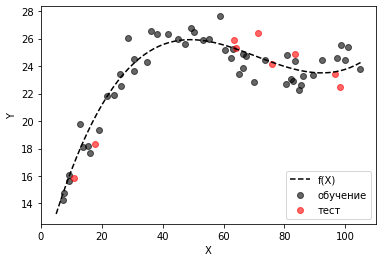

In [4]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color='black', label='обучение', alpha=0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, color='red', label='тест', alpha=0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color='black', linestyle='dashed', label='f(X)')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

## Обучаем модели и оцениваем их точность

В качестве модели используем сплайны со степенями свободы от 2 (прямая) до 40 (количество узлов равно 2/3 наблюдений). Строим модели с различным количеством степеней свободы и в каждом случае считаем среднеквадратическую ошибку модели на обучающей и тестовой выборках.    

In [5]:
# загрузка пакетов
from pandas import DataFrame
import rpy2.robjects as robjects

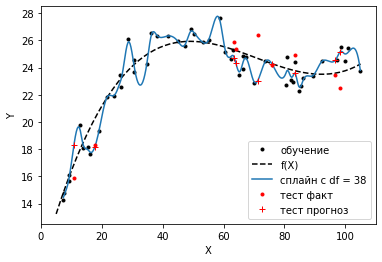

In [8]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 38

# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])

# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']

# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train_lin)).rx2('y'))

# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')

# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
          sum((y_test - y_hat_test)**2) / len(y_test)]

Ошибки на обучающей и тестовой выборках составили соответственно:

In [9]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.11, 3.32])

In [10]:
#  Теперь строим модели с df от 2 до 40 ########################################

# максимальное число степеней свободы для модели сплайна
max_df = 40

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
                       index=list(range(2, max_df+1)))

# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)

Минимум MSE на тестовой выборке достигается при числе степеней свободы:  

In [11]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
4,1.17842,1.332491


Изобразим на графике динамику MSE на обучающей и тестовой выборках в зависимости от степеней свободы модели. 

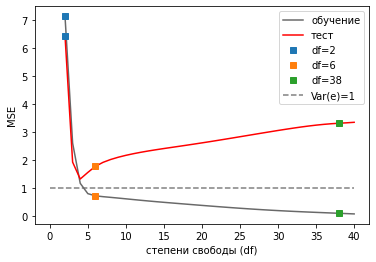

In [12]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'], MSE_all_dfs.iloc[36]['MSE_test']],
         ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

Кривая MSE на обучающей выборке стабильно снижается с ростом узлов сплайна. Чем больше наблюдений, через которые прошёл сплайн, тем точнее модель. Это говорит о переобучении. Лучшую модель следуют выбирать по минимуму на кривой MSE на тестовой выборке.  

Вывод к 1 задаче:

Наилучшее число степеней свободы для данной модели - 6, поскольку при нем достигается минимальная ошибка на тестовой выборке.
Итак, при числе степеней сводобы 6 сплайн выглядит следующим образом:

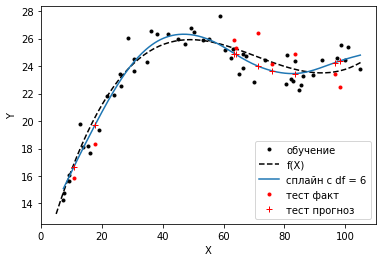

In [14]:
my_df = 6

x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

r_smooth_spline = robjects.r['smooth.spline']

fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

y_hat_train = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train_lin)).rx2('y'))

plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')

plt.xlabel('X')
plt.ylabel('Y')

plt.legend(loc='best')

MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
          sum((y_test - y_hat_test)**2) / len(y_test)]

Задание 2, вариант 16: 

ДЛЯ train_percent = 0.3

In [16]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10111)

# всего наблюдений, доля обучающей выборки
n_all, train_percent = 60, 0.3

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), 
                            replace=False)

# истинная функция взаимосвязи
def y_func (x) :
    return(25 + 0.02*x - 0.003*(x - 45)**2 + 0.00006*(x - 54)**3)
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)

### Строим графики   

Изобразим исходные данные на графике.   

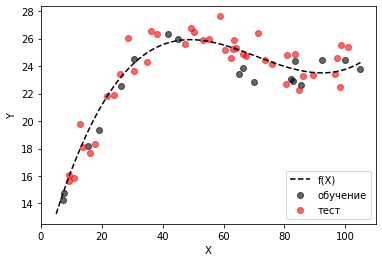

In [17]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color='black', label='обучение', alpha=0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, color='red', label='тест', alpha=0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color='black', linestyle='dashed', label='f(X)')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

## Обучаем модели и оцениваем их точность

В качестве модели используем сплайны со степенями свободы от 2 (прямая) до 40 (количество узлов равно 2/3 наблюдений). Строим модели с различным количеством степеней свободы и в каждом случае считаем среднеквадратическую ошибку модели на обучающей и тестовой выборках.  

In [19]:
max_df = 40

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
                       index=list(range(2, max_df+1)))

# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)

In [20]:
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
5,0.31316,1.623543


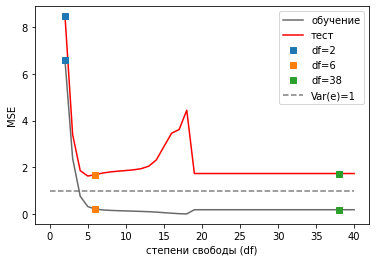

In [21]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'], MSE_all_dfs.iloc[36]['MSE_test']],
         ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

Кривая MSE на обучающей выборке снижается (до определенного момента) с ростом узлов сплайна (до 6, далее MSE снова начинает увеличиваться). Чем больше наблюдений, через которые прошёл сплайн, тем точнее модель. Это говорит о переобучении. Лучшую модель следуют выбирать по минимуму на кривой MSE на тестовой выборке. 

ДЛЯ train_percent = 0.25

In [33]:
# также задаем псевдорандонмные исходные данные
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10111)

# всего наблюдений, доля обучающей выборки
n_all, train_percent = 60, 0.25

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), 
                            replace=False)

# истинная функция взаимосвязи
def y_func (x) :
    return(25 + 0.02*x - 0.003*(x - 45)**2 + 0.00006*(x - 54)**3)
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)

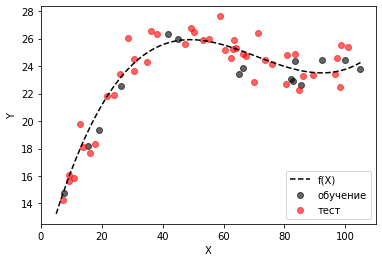

In [34]:
#  обучающая выборка
plt.scatter(x_train, y_train, color='black', label='обучение', alpha=0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, color='red', label='тест', alpha=0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color='black', linestyle='dashed', label='f(X)')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

Точно также, как и в предыдущих пунктах, определяем наилучший выбор числа степеней свободы:

In [35]:
# максимальное число степеней свободы для модели сплайна
max_df = 40

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
                       index=list(range(2, max_df+1)))

# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)

In [36]:
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
5,0.27407,1.549214


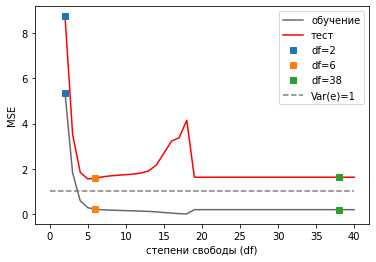

In [37]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'], MSE_all_dfs.iloc[36]['MSE_test']],
         ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

ДЛЯ train_percent = 0.2

In [42]:
# также задаем псевдорандонмные исходные данные
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10111)

# всего наблюдений, доля обучающей выборки
n_all, train_percent = 60, 0.2

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), 
                            replace=False)

# истинная функция взаимосвязи
def y_func (x) :
    return(25 + 0.02*x - 0.003*(x - 45)**2 + 0.00006*(x - 54)**3)
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)

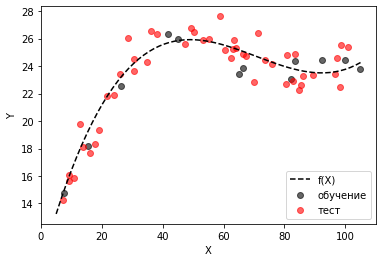

In [43]:
#  обучающая выборка
plt.scatter(x_train, y_train, color='black', label='обучение', alpha=0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, color='red', label='тест', alpha=0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color='black', linestyle='dashed', label='f(X)')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

Точно также, как и в предыдущих пунктах, определяем наилучший выбор числа степеней свободы:

In [44]:
# максимальное число степеней свободы для модели сплайна
max_df = 40

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
                       index=list(range(2, max_df+1)))

# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)

In [45]:
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
5,0.256384,1.473939


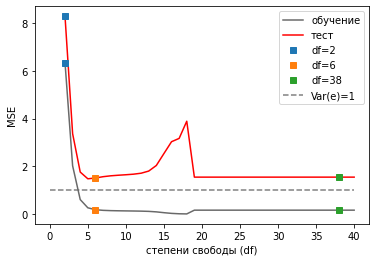

In [46]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'], MSE_all_dfs.iloc[36]['MSE_test']],
         ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

Для train_percent = 0.3 и df = 5 (тк достигается наименьший показатель MSE):
Ошибки на обучающей и тестовой выборках:
* MSE Train = 0.31316
* MSE Test = 1.623543


Для train_percent = 0.25 и df = 5 (тк достигается наименьший показатель MSE):
Ошибки на обучающей и тестовой выборках:
* MSE Train = 0.27407	
* MSE Test = 1.549214  

Для train_percent = 0.2 и df = 5 (тк достигается наименьший показатель MSE):
Ошибки на обучающей и тестовой выборках:
* MSE Train = 0.256384	
* MSE Test = 1.473939

Выводы:
* При увеличении значения train_percent, уменьшаются ошибки как на тренировочной выборке, так и на тестовой.
* С ростом числа степеней свободы, ошибки на тестовых выборках моделей увеличиваются, происходит переобучение.
* Если выбирать из этих трех моделей, то лучшая при train_percent = 0.2, т.к. в ней ошибка на тестовой выборке минимальна.